***installing Spacy 2.1.0 and neuralcoref***

> neuralcoref only works with Spacy, 2.1.0. Whilst spacy can be installe dusing Pip or Conda, to install the spacy lg english model and neuralcoref:
- https://v2.spacy.io/models/en
- manually download the model tar https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1#
- install the model locally https://github.com/explosion/spaCy/issues/4577
- install neuralcoref from source
    - https://github.com/huggingface/neuralcoref/issues/197#issuecomment-534028423
    - https://github.com/huggingface/neuralcoref#install-neuralcoref-from-source
    - https://medium.com/huggingface/state-of-the-art-neural-coreference-resolution-for-chatbots-3302365dcf30



In [1]:
import re
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import spacy
import neuralcoref #
from spacy import displacy
try:
    nlp = spacy.load('en_core_web_lg')
except:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

## Load Data

In [2]:
df = pd.read_excel('tesco.xlsx',skiprows=2)
df[:2]

,id,text
0,0,"Tesco has been hit by hackers, leaving thousan..."
1,1,The outage leaves its grocery website and app ...


## Model

- [named entity recognition]()
- [coreference resolution](https://spacy.io/universe/project/neuralcoref)

 
<img src="./model_architecture.svg" width=600 height=400>

In [3]:
example_text = ' '.join(x for x in df['text'])
print(example_text)

Tesco has been hit by hackers, leaving thousands of frustrated shoppers unable to buy groceries online at Britain’s biggest supermarket. The outage leaves its grocery website and app down for a second day, with people unable to book deliveries or amend existing orders. Tesco receives 1.3m online orders every week. A Tesco spokesperson said: “Since yesterday, we’ve been experiencing disruption to our online grocery website and app. An attempt was made to interfere with our systems, which has caused problems with the search function on the site. We’re working hard to fully restore all services and apologise for the inconvenience. “There is no reason to believe that this issue impacts customer data and we continue to take ongoing action to make sure all data stays safe.” Tesco was hacked previously in 2014, when it was forced to deactivate online customer accounts after more than 2,000 login details, including passwords, were posted online. A separate attack on Tesco’s banking arm resulte

## Named Entity Recognition
To extract the named entities

In [4]:
# custom NER
try:
    nlp.remove_pipe('entity_ruler')
#     pass
except:
    config = {
       "phrase_matcher_attr": None,
       "validate": True,
       "overwrite_ents": True,
       "ent_id_sep": "||",
    }
    ruler = nlp.create_pipe("entity_ruler", config=config)
    patterns = [
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(customer)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(shopper)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(hacker)s?' }} ]},
                ]
    ruler.add_patterns(patterns)
    ruler = nlp.add_pipe(ruler)
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7fe6d4c78e10>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fe6d4cc8de0>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fe6d4cc8e50>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x7fe6c9792a90>)]

In [5]:
doc = nlp(example_text)
# spacy.displacy.render(doc, style='dep')
print('\n\n')
spacy.displacy.render(doc, style='ent')

In [6]:
# pre-processing
df['text-clean'] = df['text'].apply(lambda x: re.sub(r"(\w+)'s", r'\1s', x))
# apply nlp
df['doc'] = df['text-clean'].apply(lambda x: nlp(x))

df[:2]

,id,text,text-clean,doc
0,0,"Tesco has been hit by hackers, leaving thousan...","Tesco has been hit by hackers, leaving thousan...","(Tesco, has, been, hit, by, hackers, ,, leavin..."
1,1,The outage leaves its grocery website and app ...,The outage leaves its grocery website and app ...,"(The, outage, leaves, its, grocery, website, a..."


### Coreference Resolution

Coreference Resolution is applied to identify and normalise mentions of the same entities within a text. To achieve this, neuralcoref evaluates the position and semantic characteristics of specific terms (e.g. entities, nouns, pronouns) within and across sentences.

In [7]:
try: 
    neuralcoref.add_to_pipe(nlp)
    print(nlp.pipeline)
except:
    print(nlp.pipeline)

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fe6d4c78e10>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fe6d4cc8de0>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fe6d4cc8e50>), ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x7fe6c9792a90>), ('neuralcoref', <neuralcoref.neuralcoref.NeuralCoref object at 0x7fe6c9711cb0>)]


In [8]:
# show initial named entities
doc = nlp(example_text)
spacy.displacy.render(doc, style='ent')

In [9]:
# show coref results
print(doc._.has_coref)
print("Coref results\t:",doc._.coref_clusters)
print("Coref resolved\t:",doc._.coref_resolved)

# interact with coref result objects
print(type(doc._.coref_scores))

# cluster mentions
k = doc._.coref_clusters
print("Entities found:\t",k)
a = k[0]
print("Entity 1:\t",a)
print("\tMention:\t",a.main.start_char,a.main.end_char)
for i in a.mentions:
    print("\tMentions:\t",i,i.start_char,i.end_char)

True
Coref results	: [Tesco: [Tesco, its, Tesco, Tesco, Tesco, it, Tesco, Tesco’s, Tesco, Tesco, Tesco, Tesco], we: [we, our, our, We, we], a cyber-attack on the Brazilian meat processor JBS, the largest in the world: [a cyber-attack on the Brazilian meat processor JBS, the largest in the world, it], Shoppers: [Shoppers, their], Some: [Some, they, them], she: [she, her], this evening: [this evening, this evening], @asda: [@asda, she, @asda], the day: [the day, the day], this morning: [this morning, this morning], Today: [Today, its], Several Tesco customers: [Several Tesco customers, they, their, them], A Tesco customer service member: [A Tesco customer service member, the company, we, we], Twitter: [Twitter, Twitter], customers: [customers, their], the driver: [the driver, it], Our IT teams: [Our IT teams, their], The rival supermarket Asda: [The rival supermarket Asda, it, we, We, our]]
Coref resolved	: Tesco has been hit by hackers, leaving thousands of frustrated shoppers unable to

In [10]:
# resolved entities
doc = nlp(doc._.coref_resolved)
spacy.displacy.render(doc, style='ent')

## Relation Extraction
To extract realtion ships we must:

### 1. Select the entities
Here there are two important considerations: I) the type of entities to select, ii) reducing those entities to a unique list. 

The type of entities selected determines what relationships and facts you will extract. Options here include: named entities by type; nouns, proper nouns and other word types; and [noun chunks](https://spacy.io/usage/linguistic-features#noun-chunkshttps://spacy.io/usage/linguistic-features#noun-chunks). 


Then, to reduce those named entities and phrases to a unique list, we could apply simple string matching, coreference resolution, or word vector similarity. 

>[***spacy vector example***](https://ashutoshtripathi.com/2020/09/04/word2vec-and-semantic-similarity-using-spacy-nlp-spacy-series-part-7/)
>    ```
>    from scipy.spatial import distance
>    def cosine_similarity(x,y):
>        return 1 - distance.cosine(x,y)
>    queen = nlp.vocab['queen'].vector
>    vqueen = nlp.vocab['king'].vector - nlp.vocab['man'].vector + nlp.vocab['woman'].vector
>    cosine_similarity(queen,vqueen)
>    |0.7880843877792358
>    ```  
>    ```
>
>    # similarity in spacy
>    t1 = nlp('king')
>    t2 = nlp('queen')
>    t1.similarity(t2)
>    ```

To start, lets just use the simple string matching on the Spacy entities that we have extracted following coreference rescoreference. 

In [11]:
## get more types of entity
# def get_entities(doc, verbose=True):
#     entities = dict()
#     for tok in doc:
#         # if tok.pos_ in ['PROPN','NOUN','PRON'] or  tok.ent_type_  != '':
#         if tok.ent_type_ in ['PERSON','ORG','GROUP']:
#             entities[tok.i] = tok # token.i is int location in doc
#             if verbose:
#                 print((tok.text,tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))
#     return entities
# entities = get_entities(doc)

## get spacy entities using dictionary
# from collections import defaultdict
# def get_spacy_entities(doc):
#     tmp = list()
#     for ent in doc.ents:
#         tmp.append({ent.text.upper():(ent.start_char,ent.end_char)})

#     out = defaultdict(list)
#     for myd in tmp:
#         for k, v in myd.items():
#             out[k].append(v)
#     return dict(out)

## get spacy entities using dataframe
def get_spacy_entities(doc):
    """
    extract Spacy named entities, by type, and formate as DataFrame.
    Note! Index of DataFrame must mirror ent_id
    """
    tmp = dict()
    num=0
    for ent in doc.ents:
        if ent.label_ in ['GROUP','GPE','PERSON','ORG',]:
            tmp[num] = dict(mention_id=num,
                            name=ent.text.upper(),
                            type=ent.label_,
                            start=ent.start_char,
                            end=ent.end_char)
            num+=1

    entities = pd.DataFrame.from_dict(data=tmp,orient='index')
    entities['ent_id'] = pd.factorize(entities['name'])[0]
    return entities

entities = get_spacy_entities(doc)
unique_entities = entities[['ent_id','name','type']].drop_duplicates(ignore_index=True)
unique_entities

,ent_id,name,type
0,0,TESCO,ORG
1,1,HACKERS,GROUP
2,2,SHOPPERS,GROUP
3,3,BRITAIN,GPE
4,4,CUSTOMER,GROUP
5,5,JBS,ORG
6,6,US,GPE
7,7,AUSTRALIA,GPE
8,8,CANADA,GPE
9,9,SARA WILLMAN,PERSON


### 2. Evaluate relationships between entities.

- rules based approach ([see this post](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/))
- model based

In [12]:
# RULE BASED METHOD
# # get ordered entity pairs
# def get_entity_pairs(iterable):
#     "s -> (s0,s1), (s1,s2), (s2, s3), ..."
#     a, b = itertools.tee(iterable)
#     next(b, None)
#     return {e:{'from':x[0],'to':x[1]} for e,x in enumerate(zip(a, b))}
# entity_pairs = get_entity_pairs(entities.keys())
# entity_pairs

# # get edge text
# def get_entity_edges(entity_pairs):
#     for k in list(entity_pairs.keys()):
#         v = entity_pairs[k]
#         edge_text = [t.text for t in doc[v['from']:v['to']+1] if t.pos_ in ['VERB','ADP','ADJ']]
#         edge_text = ' '.join(edge_text)
#         if len(edge_text) == 0:
#             del entity_pairs[k]
#         else:
#             v['edge'] = edge_text
    
# get_entity_edges(entity_pairs)
# entity_pairs

we want mention - mention 
but not if same ents

In [13]:
from itertools import permutations
import opennre
import joblib

In [14]:
try: 
    relations = joblib.load('tesco-relations.joblib')
except:
    look_forward = False
    model_nre = opennre.get_model('wiki80_bert_softmax')

    if look_forward:
        # symetrical matrix if we include all permutations
        perms = [(i,j) for i,j in permutations(entities['mention_id'], 2)]
        print(len(perms))
    else:
        # really, we only want to look forward - and this cuts model runs
        perms = [(i,j) for i,j in permutations(entities['mention_id'], 2) if j>i]
        print(len(perms))

    relations = list()
    for e,permutation in enumerate(perms):
        print(f"{e}/{len(perms)}",end='\r')
        i,j = permutation[0],permutation[1]
        h,t = tuple(entities.loc[i,['start','end']].values),tuple(entities.loc[j,['start','end']].values)
        res = permutation+(entities.loc[i,'ent_id'],entities.loc[j,'ent_id'],entities.loc[i,'name'],entities.loc[j,'name'])
        res = res + model_nre.infer({'text': doc.text,'h': {'pos': h},'t': {'pos': t}})
        relations.append(res)
        
    joblib.dump(relations,'tesco-relations.joblib')

relations[:5]

[(0, 1, 0, 1, 'TESCO', 'HACKERS', 'main subject', 0.592499315738678),
 (0, 2, 0, 2, 'TESCO', 'SHOPPERS', 'main subject', 0.482094943523407),
 (0, 3, 0, 3, 'TESCO', 'BRITAIN', 'headquarters location', 0.9869222044944763),
 (0, 4, 0, 0, 'TESCO', 'TESCO', 'subsidiary', 0.878483772277832),
 (0, 5, 0, 0, 'TESCO', 'TESCO', 'subsidiary', 0.9694608449935913)]

In [15]:
# view as a matrix
matrix = np.zeros(shape=(len(entities),len(entities)))
for r in relations: matrix[r[0]][r[1]] = r[7]
df = pd.DataFrame(matrix,columns=entities['name'], index=entities['name'])
df.iloc[:4,:]

name,TESCO,HACKERS,SHOPPERS,BRITAIN,TESCO,TESCO,TESCO,CUSTOMER,TESCO,TESCO,...,CUSTOMER,TESCO,CUSTOMER,CAMERON,ASDA,ASDA,TWITTER,ASDA,ASDA,ASDA
name,,,,,,,,,,,,,,,,,,,,,
TESCO,0.0,0.592499,0.482095,0.986922,0.878484,0.969461,0.981503,0.945180,0.945180,0.945180,...,0.945180,0.945180,0.945180,0.945180,0.945180,0.945180,0.945180,0.945180,0.945180,0.945180
HACKERS,0.0,0.000000,0.987648,0.716819,0.826801,0.751909,0.842383,0.978278,0.978278,0.978278,...,0.978278,0.978278,0.978278,0.978278,0.978278,0.978278,0.978278,0.978278,0.978278,0.978278
SHOPPERS,0.0,0.000000,0.000000,0.966678,0.746368,0.317530,0.364851,0.997853,0.997853,0.997853,...,0.997853,0.997853,0.997853,0.997853,0.997853,0.997853,0.997853,0.997853,0.997853,0.997853
BRITAIN,0.0,0.000000,0.000000,0.000000,0.851899,0.554888,0.768916,0.656831,0.656831,0.656831,...,0.656831,0.656831,0.656831,0.656831,0.656831,0.656831,0.656831,0.656831,0.656831,0.656831


In [16]:
# view as dataframe
df = pd.DataFrame(relations,columns=['source_mention','target_mention','source_id','target_id','name1','name2','relation','score'])
df['type1'] = df['source_id'].map(dict(entities[['ent_id','type']].values))
df['type2'] = df['target_id'].map(dict(entities[['ent_id','type']].values))
df[:4]

,source_mention,target_mention,source_id,target_id,name1,name2,relation,score,type1,type2
0,0,1,0,1,TESCO,HACKERS,main subject,0.592499,ORG,GROUP
1,0,2,0,2,TESCO,SHOPPERS,main subject,0.482095,ORG,GROUP
2,0,3,0,3,TESCO,BRITAIN,headquarters location,0.986922,ORG,GPE
3,0,4,0,0,TESCO,TESCO,subsidiary,0.878484,ORG,ORG


On interogation of the results, it seems that some relationship types have varying levels of accuracy and relevancy. We can define some simple heuristics to "prune" relationship types that make sense and by accrucay. Naturally, these rules are sensitive to the training data, model tuning, and prediction dataset.

In [17]:
## pruning
df['keep'] = False

# low score, location related
low_relations = ['country of citizenship', 'country of origin', 'headquarters location','part of']
low_threshold=0.5
df.loc[(df['relation'].isin(low_relations)) & (df['score']>=low_threshold) & (df['type2']=='GPE'),'keep']=True

# high score, not same entity
high_threshold = 0.95
df.loc[(df['source_id']!=df['target_id']) & (~df['relation'].isin(low_relations))  & (df['score']>=high_threshold),'keep']=True

# PERSON cannot be owned by ORG
df.loc[(df['type1']=='PERSON') & (df['type2']=='ORG'),'keep']=False

# df.loc[df['relation'].isin(['main subject','has part']),'keep']=False

entity_relationships = df.loc[df['keep']==True].reset_index(drop=True)
entity_relationships[:3]

,source_mention,target_mention,source_id,target_id,name1,name2,relation,score,type1,type2,keep
0,0,3,0,3,TESCO,BRITAIN,headquarters location,0.986922,ORG,GPE,True
1,1,2,1,2,HACKERS,SHOPPERS,main subject,0.987648,GROUP,GROUP,True
2,1,3,1,3,HACKERS,BRITAIN,country of origin,0.716819,GROUP,GPE,True


## Visualise Entity Relationships

In [103]:
from networkx.algorithms.community import greedy_modularity_communities
import community
import matplotlib.cm as cm

In [104]:
# create graph
G=nx.Graph(name='simple KG')

# add nodes
for ix,row in unique_entities.iterrows():
    G.add_node(row['ent_id'],name=row['name'], ent_typ=row['type']) 
node_labels = {node[0]:node[1]['name'] for node in G.nodes(data=True)}

# add edges
edges = [(row['source_id'],row['target_id'],{'weight':1, 'relation':row['relation']}) for ix,row in entity_relationships.iterrows()]
edge_labels = {(row['source_id'],row['target_id']):row['relation'] for ix,row in entity_relationships.iterrows()}
G.add_edges_from(edges)

# save
joblib.dump(G,'graph.joblib')

['graph.joblib']

In [105]:
# compute the best partition

# for un-directed graphs
# partition = community.best_partition(G)
# node_color=list(partition.values

# for directed graphs
c = list(greedy_modularity_communities(G))
node_color=dict()
for e,s in enumerate(c):
    for n in s:
        node_color[n] = e
node_color = [node_color[k] for k in sorted(node_color.keys())]

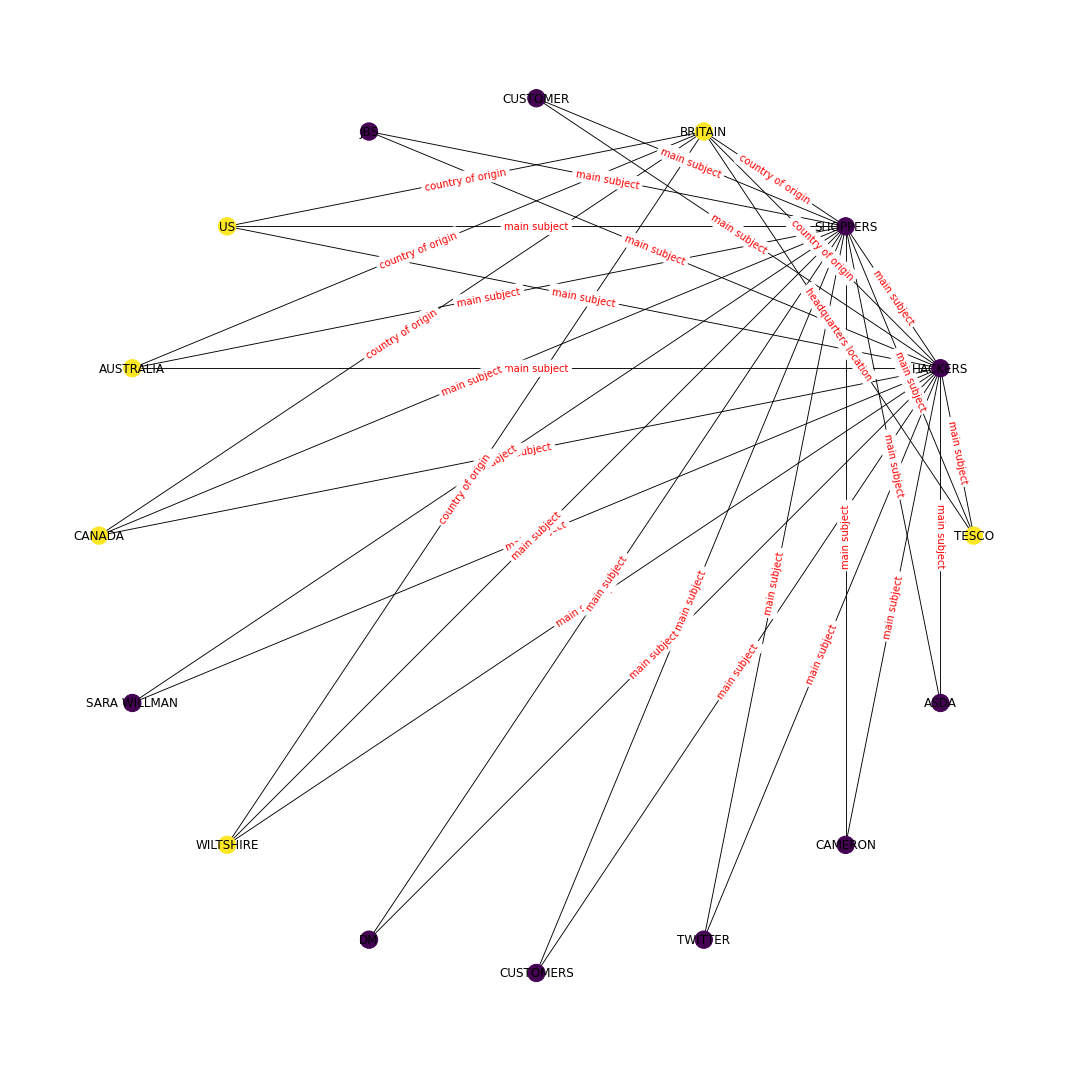

In [106]:
# plot graph
fig,ax = plt.subplots(1,1, figsize=(15,15))
pos = nx.circular_layout(G)


nx.draw(G, 
        ax=ax,
        pos=pos,
        node_color=node_color,
        labels=node_labels,
        width=0.9)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels,
                             font_color='red')
plt.tight_layout()